# Lasso after lasso

When I performed lasso regression in 30,000 dimension data, I found the variable is reduced to around 60 but it is still many. This program perform lasso again to see what will happen.

# DREAM Preterm Birth Prediction challenge

This is analysis of data competition "DREAM Preterm Birth Prediction challenge". The goal is to predict the gestational age, the months from the last period after pregnancy and the child birth, based on the blood genome data. The main difficulty is to extract important features from the data, which has 30,000 columns.

# Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import math
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers

# Data 

The following data was preprocessed in R, by merging eset_HTA20 and anoSC1_v11_nokey.csv. It contains both train and test observations.

In [2]:
alldata = pd.read_csv("alldata.csv")
alldata.head()

,Unnamed: 0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_32827,g_32828,g_32829,g_32830,SampleID,GA,Batch,Set,Train,Platform
0,1,6.062215,3.796484,5.849338,3.567779,6.166815,4.443027,5.836522,6.330018,4.922339,...,8.972873,10.440245,12.101476,13.695705,Tarca_001_P1A01,11.0,1,PRB_HTA,1,HTA20
1,2,6.125023,3.805305,6.191562,3.452524,5.678373,4.773199,6.143398,5.601745,4.711765,...,9.376194,10.845176,12.370891,13.635522,Tarca_003_P1A03,NaN,1,PRB_HTA,0,HTA20
2,3,5.875502,3.450245,6.550525,3.316134,6.185059,4.393488,5.898364,6.137984,4.628124,...,8.843612,10.493416,12.295786,13.616688,Tarca_004_P1A04,32.6,1,PRB_HTA,1,HTA20
3,4,6.126131,3.628411,6.421877,3.432451,5.633757,4.623783,6.019792,5.787502,4.796283,...,9.191471,10.879879,12.249936,13.524328,Tarca_005_P1A05,30.6,1,PRB_HTA,1,HTA20
4,5,6.146466,3.446812,6.260962,3.477162,5.313198,4.422651,6.407699,5.830437,4.726488,...,9.247768,10.754316,12.245458,13.509353,Tarca_006_P1A06,NaN,1,PRB_HTA,0,HTA20


# Train and test split

In [3]:
X_train_df = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']
y_train_df = alldata.loc[alldata['Train'] == 1, 'GA']
X_test_df = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830']
ID_test_df = alldata.loc[alldata['Train'] == 0, 'SampleID']
print("X_train dimension:", X_train_df.shape)
print("y_train dimension:", y_train_df.shape)
print("X_test dimension:", X_test_df.shape)

X_train dimension: (367, 32830)
y_train dimension: (367,)
X_test dimension: (368, 32830)


# EDA

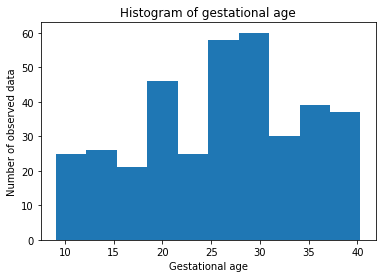

In [4]:
_ = plt.hist(y_train_df)
_ = plt.xlabel("Gestational age")
_ = plt.ylabel("Number of observed data")
_ = plt.title("Histogram of gestational age")
plt.show()

# Hyperparameter tuning with GridSearchCV

Use GridSearchCV and apply 10-fold cross valadation to tune alpha parameter of lasso.

In [30]:
k = 10
alpha_lower = 0.01
alpha_upper = 0.1

# Setup the parameter grid
alpha_space = np.arange(alpha_lower, alpha_upper, 0.01)
# alpha_space = np.arange(alpha_lower, alpha_upper, 0.005)
param_grid = {'alpha':alpha_space}

# Instantiate a lasso regression
lasso = Lasso(normalize = True)

# Instantiate the GridSearchCV object
lasso_cv = GridSearchCV(lasso, param_grid, cv = k)

# Fit it to data
lasso_cv.fit(X_train_df.values, y_train_df.values)

# Calculate training accuracy by RMSE
y_pred = lasso_cv.predict(X_train_df.values)
rmse = math.sqrt(statistics.mean((y_train_df.values - y_pred)**2))

# Predictors
best_alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha = best_alpha, normalize = True)
lasso.fit(X_train_df.values, y_train_df.values)
lasso_coef = lasso.coef_
p = sum(abs(lasso_coef) > 0)

# Print the tuned parameters and score
print("Tuned lasso regression hyperparameters: {}".format(lasso_cv.best_params_))
print("Best score: {0:.2f}".format(lasso_cv.best_score_))
print("RMSE: {0:.2f}".format(rmse))
print("Number of predictors: {}".format(p))

C:\Users\yukic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned lasso regression hyperparameters: {'alpha': 0.04}
Best score: 0.37
RMSE: 5.25
Number of predictors: 59


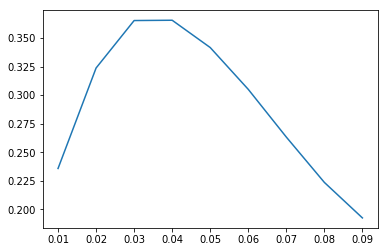

In [31]:
_ = plt.plot(alpha_space, lasso_cv.cv_results_['mean_test_score'])
plt.show()

The above allows us to have the best alpha hyperparameter which acchieve the best accuracy in the validation dataset, and RMSE improved. But we still have 59 predictors and we might have overfitting, and I want to reduce the number of predictors further.

In [32]:
COLUMNS = X_train_df.columns
COLUMNS[abs(lasso_coef) > 0]

Index(['g_966', 'g_1096', 'g_3102', 'g_3825', 'g_4092', 'g_4126', 'g_4321',
       'g_5176', 'g_5687', 'g_5745', 'g_5795', 'g_5957', 'g_6330', 'g_6781',
       'g_8280', 'g_8660', 'g_8923', 'g_10026', 'g_10446', 'g_10514',
       'g_11289', 'g_11722', 'g_12337', 'g_14088', 'g_15239', 'g_15638',
       'g_16524', 'g_17136', 'g_17631', 'g_17659', 'g_17724', 'g_17792',
       'g_17891', 'g_21693', 'g_22158', 'g_22394', 'g_22398', 'g_22824',
       'g_22840', 'g_22893', 'g_24604', 'g_25582', 'g_25719', 'g_25724',
       'g_25865', 'g_26524', 'g_26873', 'g_26984', 'g_27130', 'g_27491',
       'g_27739', 'g_27948', 'g_28122', 'g_28914', 'g_29804', 'g_30179',
       'g_30426', 'g_30914', 'g_32432'],
      dtype='object')

My first trail submission includes, g_14088, g_15452, g_16391, g_22398, g_22824, g_27389, g_32432. By using gridsearchCV to obtain best predictors, the result includes some from my first trial submission.

# Lasso after lasso

In [33]:
COLUMNS_lasso_best = X_train_df.columns
COLUMNS_lasso_best = COLUMNS_lasso_best[abs(lasso_coef) > 0]
subset = X_train_df[COLUMNS_lasso_best]
print(X_train_df.shape)
print(subset.shape)

(367, 32830)
(367, 59)


Tuned lasso regression hyperparameters: {'alpha': 0.0029}
Best score: 0.67
RMSE: 5.25
Number of predictors: 56


C:\Users\yukic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


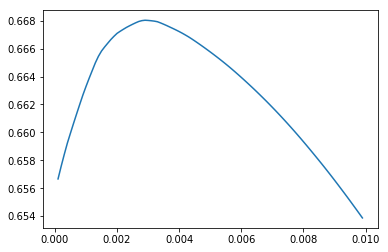

In [34]:
k = 10
alpha_lower = 0.0001
alpha_upper = 0.01

# Setup the parameter grid
# alpha_space = np.arange(alpha_lower, alpha_upper, 0.01)
alpha_space = np.arange(alpha_lower, alpha_upper, 0.0001)
param_grid = {'alpha':alpha_space}

# Instantiate a lasso regression
lasso = Lasso(normalize = True)

# Instantiate the GridSearchCV object
lasso_cv_2 = GridSearchCV(lasso, param_grid, cv = k)

# Fit it to data
lasso_cv_2.fit(subset.values, y_train_df.values)

# Calculate training accuracy by RMSE
y_pred_2 = lasso_cv_2.predict(subset.values)
rmse_2 = math.sqrt(statistics.mean((y_train_df.values - y_pred)**2))

# Predictors
best_alpha_2 = lasso_cv_2.best_params_['alpha']
lasso = Lasso(alpha = best_alpha_2, normalize = True)
lasso.fit(subset.values, y_train_df.values)
lasso_coef_2 = lasso.coef_
p_2 = sum(abs(lasso_coef_2) > 0)

# Print the tuned parameters and score
print("Tuned lasso regression hyperparameters: {}".format(lasso_cv_2.best_params_))
print("Best score: {0:.2f}".format(lasso_cv_2.best_score_))
print("RMSE: {0:.2f}".format(rmse_2))
print("Number of predictors: {}".format(p_2))

# Check alpha and score
_ = plt.plot(alpha_space, lasso_cv_2.cv_results_['mean_test_score'])
plt.show()

Performing lasso regression in the subset of training data obtrained by variable selection of lasso regression didn't reduce the dimension anymore much.